<a href="https://colab.research.google.com/github/morwald/ada_project/blob/master/Algos_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json
import bz2

In [3]:
# Comment the files which aren't stored locally
# In Colab everything should be available
QUOTES_2020_PATH = 'Merged data/quotes-2020-gb.pkl'
QUOTES_2019_PATH = 'Merged data/quotes-2019-gb.pkl' 
QUOTES_2018_PATH = 'Merged data/quotes-2018-gb.pkl'  
QUOTES_2017_PATH = 'Merged data/quotes-2017-gb.pkl'
QUOTES_2016_PATH = 'Merged data/quotes-2016-gb.pkl'
QUOTES_2015_PATH = 'Merged data/quotes-2015-gb.pkl'

In [4]:
use_colab = True

In [5]:
# Import with EPFL google drive!
if use_colab:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    
    %cd /content/drive/Shareddrives/ADA-project

Mounted at /content/drive
/content/drive/Shareddrives/ADA-project


# LDA algo 1 (https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/)


In [6]:
!pip install pyldavis

In [10]:
import nltk; nltk.download('stopwords')

import re
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models  # don't skip this
pyLDAvis.enable_notebook()
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [12]:
df = pd.read_json('https://raw.githubusercontent.com/selva86/datasets/master/newsgroups.json')
print(df.target_names.unique())
df.head()

['rec.autos' 'comp.sys.mac.hardware' 'comp.graphics' 'sci.space'
 'talk.politics.guns' 'sci.med' 'comp.sys.ibm.pc.hardware'
 'comp.os.ms-windows.misc' 'rec.motorcycles' 'talk.religion.misc'
 'misc.forsale' 'alt.atheism' 'sci.electronics' 'comp.windows.x'
 'rec.sport.hockey' 'rec.sport.baseball' 'soc.religion.christian'
 'talk.politics.mideast' 'talk.politics.misc' 'sci.crypt']


,content,target,target_names
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,7,rec.autos
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,4,comp.sys.mac.hardware
2,From: twillis@ec.ecn.purdue.edu (Thomas E Will...,4,comp.sys.mac.hardware
3,From: jgreen@amber (Joe Green)\nSubject: Re: W...,1,comp.graphics
4,From: jcm@head-cfa.harvard.edu (Jonathan McDow...,14,sci.space


In [18]:
# Convert to list
data = pd.read_pickle(QUOTES_2020_PATH).quotation.tolist()

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

pprint(data[:1])

['As you reach or have reached the apex of your career, you build a certain '
 'level of resilience to block things out,']


In [19]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['as', 'you', 'reach', 'or', 'have', 'reached', 'the', 'apex', 'of', 'your', 'career', 'you', 'build', 'certain', 'level', 'of', 'resilience', 'to', 'block', 'things', 'out']]


In [20]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


['as', 'you', 'reach', 'or', 'have', 'reached', 'the', 'apex', 'of', 'your', 'career', 'you', 'build', 'certain', 'level', 'of', 'resilience', 'to', 'block', 'things', 'out']


In [21]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out


In [22]:

# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['reach', 'apex', 'career', 'build', 'certain', 'level', 'resilience', 'block', 'thing']]


In [23]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1)]]


In [24]:
id2word[0]

'apex'

In [25]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('apex', 1),
  ('block', 1),
  ('build', 1),
  ('career', 1),
  ('certain', 1),
  ('level', 1),
  ('reach', 1),
  ('resilience', 1),
  ('thing', 1)]]

Build LDA model

In [26]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)


In [ ]:
# Print the Keyword in the 20 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

In [28]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.906072636367902

Coherence Score:  0.3135580457546138


In [30]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
7     -0.442873 -0.058982       1        1  9.470854
11    -0.032779  0.426489       2        1  6.409726
16    -0.014252  0.027197       3        1  5.967595
5      0.023833 -0.025592       4        1  5.140472
10     0.025846 -0.021439       5        1  5.027358
14     0.015508 -0.018271       6        1  5.014985
19     0.022342 -0.018300       7        1  4.967827
18     0.024439 -0.023249       8        1  4.930100
12     0.027760 -0.019070       9        1  4.913495
9      0.024468 -0.017726      10        1  4.781028
0      0.028525 -0.022549      11        1  4.732669
1      0.018310 -0.024087      12        1  4.685422
6      0.023068 -0.019228      13        1  4.637868
15     0.028201 -0.023545      14        1  4.529699
3      0.037275 -0.027059      15        1  4.316752
4      0.032659 -0.022123      16        1  4.310674
13     0.037501 -0.026851      17        1  4.190916
2      0.038139 -0.027302      18        1  4.114322
17     0.038377 -0.028484      19        1  3.950465
8      0.043652 -0.029830      20        1  3.907773, topic_info=               Term         Freq        Total Category  logprob  loglift
105           would  1994.000000  1994.000000  Default  30.0000  30.0000
55           people  1961.000000  1961.000000  Default  29.0000  29.0000
37               be  2479.000000  2479.000000  Default  28.0000  28.0000
41               go  2383.000000  2383.000000  Default  27.0000  27.0000
200             get  1880.000000  1880.000000  Default  26.0000  26.0000
...             ...          ...          ...      ...      ...      ...
1213  international    64.978709    65.874912  Topic20  -4.8462   3.2285
2109         nature    64.554006    65.450209  Topic20  -4.8528   3.2284
523         culture    62.445987    63.342189  Topic20  -4.8860   3.2280
1681           self    61.982932    62.879135  Topic20  -4.8934   3.2278
1985     particular    60.552498    61.448701  Topic20  -4.9168   3.2275

[630 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
1112     19  0.985834     ability
106      11  0.997612        able
868      13  0.994550  absolutely
490      18  0.986903      access
446      14  0.997639         act
...     ...       ...         ...
910       1  0.992299       wrong
29        5  0.998663        year
3384      6  0.986621   yesterday
1502     11  0.989045         yet
376      18  0.993718       young

[600 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 12, 17, 6, 11, 15, 20, 19, 13, 10, 1, 2, 7, 16, 4, 5, 14, 3, 18, 9])

In [ ]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
mallet_path = 'C:/mallet-2.0.8/bin/mallet.bat' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

In [40]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
      model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
      #model2 = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
      model_list.append(model)
      coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
      coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [41]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

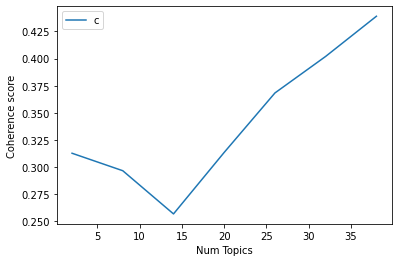

In [42]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [43]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.3127
Num Topics = 8  has Coherence Value of 0.2966
Num Topics = 14  has Coherence Value of 0.2568
Num Topics = 20  has Coherence Value of 0.3136
Num Topics = 26  has Coherence Value of 0.3683
Num Topics = 32  has Coherence Value of 0.402
Num Topics = 38  has Coherence Value of 0.439


In [79]:
# Select the model and print the topics
optimal_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=5, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
model_topics = optimal_model.show_topics(formatted=False)

In [80]:
coherencemodel = CoherenceModel(model=optimal_model, texts=texts, dictionary=id2word, coherence='c_v')
coherencemodel.get_coherence()

0.3294981370989468

In [81]:
vis = pyLDAvis.gensim_models.prepare(optimal_model, corpus, id2word)
vis

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.223394 -0.281611       1        1  23.505104
0     -0.339992 -0.133487       2        1  22.936179
4      0.049154  0.213976       3        1  19.692460
1      0.037701  0.128942       4        1  17.900812
3      0.029743  0.072179       5        1  15.965445, topic_info=        Term         Freq        Total Category  logprob  loglift
37        be  2485.000000  2485.000000  Default  30.0000  30.0000
41        go  2388.000000  2388.000000  Default  29.0000  29.0000
55    people  1964.000000  1964.000000  Default  28.0000  28.0000
65         s  2174.000000  2174.000000  Default  27.0000  27.0000
105    would  2065.000000  2065.000000  Default  26.0000  26.0000
...      ...          ...          ...      ...      ...      ...
53     happy   198.739048   199.517488   Topic5  -5.1357   1.8308
1477    high   193.258578   194.030683   Topic5  -5.1637   1.8308
399     plan   184.191787   184.963511   Topic5  -5.2118   1.8306
493     grow   182.265466   183.041433   Topic5  -5.2223   1.8305
127     sort   182.839864   183.622152   Topic5  -5.2191   1.8305

[181 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
106       1  0.997112     able
491       4  0.996551  already
669       1  0.998265     also
447       1  0.998225   always
1024      3  0.996891      ask
...     ...       ...      ...
67        2  0.999156    world
105       1  0.999411    would
29        3  0.999579     year
376       1  0.004330    young
376       4  0.991591    young

[152 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 5, 2, 4])

In [82]:
def take_second(elem):
    return elem[1]

def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row[0], key=take_second, reverse=True)        
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,0.0,0.2693,"be, go, s, get, think, want, say, feel, love, ...",As you reach or have reached the apex of your ...
1,1,3.0,0.2682,"take, could, even, support, help, government, ...",At the same time we want to remain friends wit...
2,2,4.0,0.3561,"know, make, really, come, see, good, need, yea...",Been home-schooling a 6-year-old and 8-year-ol...
3,3,1.0,0.2587,"people, have, thing, work, way, life, never, t...",I am now in agreement that we should move forw...
4,4,0.0,0.2707,"be, go, s, get, think, want, say, feel, love, ...",I dont want to make a career out of [ remaking...
5,5,0.0,0.2463,"be, go, s, get, think, want, say, feel, love, ...",Im not in medieval times!
6,6,1.0,0.2580,"people, have, thing, work, way, life, never, t...","It was a lot of fun, it was like a football ga..."
7,7,4.0,0.2836,"know, make, really, come, see, good, need, yea...",We still need to have our critical infrastruct...
8,8,2.0,0.2219,"would, time, look, day, well, also, can, give,...",Your positivity on screen makes so many people...
9,9,0.0,0.3651,"be, go, s, get, think, want, say, feel, love, ...","At this moment, when theres so much fear in th..."


In [83]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head()

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.4066,"be, go, s, get, think, want, say, feel, love, ...","So hes a bit like George Maharis, hes a bit li..."
1,1.0,0.3546,"people, have, thing, work, way, life, never, t...",So the anti-tobacco people have got to attack ...
2,2.0,0.3805,"would, time, look, day, well, also, can, give,...","Lastly, keeping loose condoms in your wallet, ..."
3,3.0,0.3621,"take, could, even, support, help, government, ...",The government needs to do an awful lot more t...
4,4.0,0.3681,"know, make, really, come, see, good, need, yea...",We need everyone to continue to comply with th...


In [87]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics.head(5)

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,0.0,"be, go, s, get, think, want, say, feel, love, ...",9054.0,0.3473
1.0,3.0,"take, could, even, support, help, government, ...",631.0,0.0242
2.0,4.0,"know, make, really, come, see, good, need, yea...",14066.0,0.5395
3.0,1.0,"people, have, thing, work, way, life, never, t...",236.0,0.0091
4.0,0.0,"be, go, s, get, think, want, say, feel, love, ...",2083.0,0.0799


In [93]:
for i in range(0,5):
  print(str(i) + " " + df_dominant_topics.Topic_Keywords[i])

0 be, go, s, get, think, want, say, feel, love, back
1 take, could, even, support, help, government, show, change, talk, live
2 know, make, really, come, see, good, need, year, still, big
3 people, have, thing, work, way, life, never, try, many, right
4 be, go, s, get, think, want, say, feel, love, back


# LDA 2 (https://towardsdatascience.com/topic-modeling-and-latent-dirichlet-allocation-in-python-9bf156893c24)

In [112]:
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
from nltk.stem import PorterStemmer
import numpy as np
np.random.seed(2018)
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [115]:
def lemmatize_stemming(text):
    ps = PorterStemmer()
    return ps.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result

In [109]:
documents = pd.read_pickle(QUOTES_2020_PATH)[['quotation']]
documents['index'] = documents.index
documents.head()

,quotation,index
0,As you reach or have reached the apex of your ...,0
1,At the same time we want to remain friends wit...,1
2,Been home-schooling a 6-year-old and 8-year-ol...,2
3,I am now in agreement that we should move forw...,3
4,I don't want to make a career out of [ remakin...,4


In [116]:

doc_sample = documents[documents['index'] == 4310].values[0][0]
print('original document: ')
words = []
for word in doc_sample.split(' '):
    words.append(word)
print(words)
print('\n\n tokenized and lemmatized document: ')
print(preprocess(doc_sample))

original document: 
['Urgh,', 'my', 'ovaries', 'are', 'crying', 'all', 'the', 'time.', "They're", 'screaming!', 'I', 'cannot', 'wait', 'because', 'all', 'five', 'of', 'them', 'are', 'going', 'to', 'be', 'the', 'best', 'children.']


 tokenized and lemmatized document: 
['urgh', 'ovari', 'cri', 'time', 'scream', 'wait', 'go', 'best', 'children']


In [117]:
processed_docs = documents['quotation'].map(preprocess)
processed_docs[:10]

0    [reach, reach, apex, career, build, certain, l...
1    [time, want, remain, friend, european, neighbo...
2    [home, school, year, year, hour, minut, teache...
3                 [agreement, forward, claim, process]
4                         [want, career, remak, paint]
5                                       [mediev, time]
6    [like, footbal, game, rock, concert, go, wasn,...
7    [need, critic, infrastructur, continu, work, f...
8     [posit, screen, make, peopl, happi, worri, time]
9    [moment, fear, countri, fear, world, need, ame...
Name: quotation, dtype: object

In [118]:
dictionary = gensim.corpora.Dictionary(processed_docs)
count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

0 apex
1 block
2 build
3 career
4 certain
5 level
6 reach
7 resili
8 thing
9 drink
10 european


In [119]:
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000) ## TODO 15 un peu haut peut-être

In [120]:
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]
bow_corpus[4310]

[(17, 1), (37, 1), (178, 1), (256, 1), (510, 1), (1253, 1), (1776, 1)]

In [121]:
bow_doc_4310 = bow_corpus[4310]
for i in range(len(bow_doc_4310)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_4310[i][0], 
                                               dictionary[bow_doc_4310[i][0]], 
bow_doc_4310[i][1]))

Word 17 ("time") appears 1 time.
Word 37 ("go") appears 1 time.
Word 178 ("wait") appears 1 time.
Word 256 ("best") appears 1 time.
Word 510 ("children") appears 1 time.
Word 1253 ("cri") appears 1 time.
Word 1776 ("scream") appears 1 time.


In [122]:
from gensim import corpora, models
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]
from pprint import pprint
for doc in corpus_tfidf:
    pprint(doc)
    break

[(0, 0.3438644481742555),
 (1, 0.2584543510844445),
 (2, 0.303242388627149),
 (3, 0.30642107980151123),
 (4, 0.2524401930107772),
 (5, 0.6182173108948154),
 (6, 0.39249041862471246),
 (7, 0.17070835372287213)]


In [129]:
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=6, id2word=dictionary, passes=2, workers=2)

In [130]:
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.036*"think" + 0.026*"go" + 0.024*"time" + 0.018*"thing" + 0.015*"like" + 0.011*"feel" + 0.011*"life" + 0.010*"right" + 0.010*"peopl" + 0.007*"best"
Topic: 1 
Words: 0.030*"want" + 0.019*"love" + 0.014*"world" + 0.012*"feel" + 0.010*"good" + 0.010*"know" + 0.010*"like" + 0.009*"peopl" + 0.009*"work" + 0.007*"go"
Topic: 2 
Words: 0.013*"year" + 0.011*"home" + 0.010*"go" + 0.010*"thing" + 0.010*"stay" + 0.009*"come" + 0.009*"happen" + 0.008*"take" + 0.008*"work" + 0.007*"leav"
Topic: 3 
Words: 0.038*"peopl" + 0.016*"need" + 0.008*"countri" + 0.008*"think" + 0.006*"chang" + 0.006*"health" + 0.006*"help" + 0.006*"right" + 0.006*"work" + 0.005*"case"
Topic: 4 
Words: 0.025*"come" + 0.021*"think" + 0.020*"time" + 0.011*"person" + 0.010*"like" + 0.010*"peopl" + 0.009*"need" + 0.009*"live" + 0.009*"week" + 0.008*"test"
Topic: 5 
Words: 0.041*"like" + 0.035*"know" + 0.025*"look" + 0.018*"go" + 0.017*"say" + 0.013*"work" + 0.012*"year" + 0.010*"want" + 0.006*"peopl" + 0.006*"ti

In [132]:
lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=6, id2word=dictionary, passes=2, workers=4)
for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

Topic: 0 Word: 0.014*"think" + 0.008*"go" + 0.007*"want" + 0.007*"happen" + 0.006*"better" + 0.006*"peopl" + 0.006*"like" + 0.006*"right" + 0.005*"time" + 0.005*"know"
Topic: 1 Word: 0.015*"like" + 0.009*"good" + 0.009*"feel" + 0.008*"come" + 0.006*"think" + 0.006*"go" + 0.006*"time" + 0.006*"thing" + 0.006*"peopl" + 0.005*"year"
Topic: 2 Word: 0.011*"look" + 0.007*"need" + 0.006*"think" + 0.006*"like" + 0.006*"want" + 0.005*"play" + 0.005*"peopl" + 0.005*"know" + 0.005*"go" + 0.005*"come"
Topic: 3 Word: 0.011*"peopl" + 0.009*"time" + 0.007*"say" + 0.007*"go" + 0.007*"like" + 0.007*"know" + 0.006*"need" + 0.006*"think" + 0.005*"want" + 0.005*"kill"
Topic: 4 Word: 0.015*"know" + 0.010*"work" + 0.008*"peopl" + 0.007*"year" + 0.007*"tell" + 0.007*"think" + 0.007*"like" + 0.005*"happi" + 0.005*"live" + 0.005*"want"
Topic: 5 Word: 0.011*"go" + 0.011*"love" + 0.011*"want" + 0.011*"thing" + 0.007*"time" + 0.006*"peopl" + 0.006*"think" + 0.006*"like" + 0.006*"life" + 0.006*"mean"


In [133]:
processed_docs[4310]

['urgh', 'ovari', 'cri', 'time', 'scream', 'wait', 'go', 'best', 'children']

In [134]:
for index, score in sorted(lda_model[bow_corpus[4310]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model.print_topic(index, 10)))


Score: 0.5747553110122681	 
Topic: 0.036*"think" + 0.026*"go" + 0.024*"time" + 0.018*"thing" + 0.015*"like" + 0.011*"feel" + 0.011*"life" + 0.010*"right" + 0.010*"peopl" + 0.007*"best"

Score: 0.2492092400789261	 
Topic: 0.025*"come" + 0.021*"think" + 0.020*"time" + 0.011*"person" + 0.010*"like" + 0.010*"peopl" + 0.009*"need" + 0.009*"live" + 0.009*"week" + 0.008*"test"

Score: 0.11316174268722534	 
Topic: 0.038*"peopl" + 0.016*"need" + 0.008*"countri" + 0.008*"think" + 0.006*"chang" + 0.006*"health" + 0.006*"help" + 0.006*"right" + 0.006*"work" + 0.005*"case"

Score: 0.021070359274744987	 
Topic: 0.041*"like" + 0.035*"know" + 0.025*"look" + 0.018*"go" + 0.017*"say" + 0.013*"work" + 0.012*"year" + 0.010*"want" + 0.006*"peopl" + 0.006*"time"

Score: 0.020901814103126526	 
Topic: 0.013*"year" + 0.011*"home" + 0.010*"go" + 0.010*"thing" + 0.010*"stay" + 0.009*"come" + 0.009*"happen" + 0.008*"take" + 0.008*"work" + 0.007*"leav"

Score: 0.020901566371321678	 
Topic: 0.030*"want" + 0.019*"l

In [135]:
for index, score in sorted(lda_model_tfidf[bow_corpus[4310]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model_tfidf.print_topic(index, 10)))


Score: 0.5148168802261353	 
Topic: 0.015*"like" + 0.009*"good" + 0.009*"feel" + 0.008*"come" + 0.006*"think" + 0.006*"go" + 0.006*"time" + 0.006*"thing" + 0.006*"peopl" + 0.005*"year"

Score: 0.40106096863746643	 
Topic: 0.011*"peopl" + 0.009*"time" + 0.007*"say" + 0.007*"go" + 0.007*"like" + 0.007*"know" + 0.006*"need" + 0.006*"think" + 0.005*"want" + 0.005*"kill"

Score: 0.02116916887462139	 
Topic: 0.011*"look" + 0.007*"need" + 0.006*"think" + 0.006*"like" + 0.006*"want" + 0.005*"play" + 0.005*"peopl" + 0.005*"know" + 0.005*"go" + 0.005*"come"

Score: 0.021026279777288437	 
Topic: 0.011*"go" + 0.011*"love" + 0.011*"want" + 0.011*"thing" + 0.007*"time" + 0.006*"peopl" + 0.006*"think" + 0.006*"like" + 0.006*"life" + 0.006*"mean"

Score: 0.020982418209314346	 
Topic: 0.014*"think" + 0.008*"go" + 0.007*"want" + 0.007*"happen" + 0.006*"better" + 0.006*"peopl" + 0.006*"like" + 0.006*"right" + 0.005*"time" + 0.005*"know"

Score: 0.020944319665431976	 
Topic: 0.015*"know" + 0.010*"work" + 

# LDA 3 (https://www.analyticsvidhya.com/blog/2016/08/beginners-guide-to-topic-modeling-in-python/)

In [139]:
doc_complete = pd.read_pickle(QUOTES_2020_PATH).quotation.tolist()
doc_complete[:3]

['As you reach or have reached the apex of your career, you build a certain level of resilience to block things out,',
 'At the same time we want to remain friends with our European neighbours and offer a range of drinks at an excellent price.',
 'Been home-schooling a 6-year-old and 8-year-old for 1 hour and 11 minutes. Teachers deserve to make a billion dollars a year. Or WEEK.']

In [140]:
from nltk.corpus import stopwords 
from nltk.stem.wordnet import WordNetLemmatizer
import string

stop = set(stopwords.words('english'))
exclude = set(string.punctuation) 
lemma = WordNetLemmatizer()
def clean(doc):
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    return normalized

doc_clean = [clean(doc).split() for doc in doc_complete]
doc_clean[:3]

[['reach',
  'reached',
  'apex',
  'career',
  'build',
  'certain',
  'level',
  'resilience',
  'block',
  'thing',
  'out'],
 ['time',
  'want',
  'remain',
  'friend',
  'european',
  'neighbour',
  'offer',
  'range',
  'drink',
  'excellent',
  'price'],
 ['homeschooling',
  '6yearold',
  '8yearold',
  '1',
  'hour',
  '11',
  'minute',
  'teacher',
  'deserve',
  'make',
  'billion',
  'dollar',
  'year',
  'week']]

In [141]:
# Importing Gensim
import gensim
from gensim import corpora

# Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)

# Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]

In [148]:
# Creating the object for LDA model using gensim library
Lda = gensim.models.LdaMulticore
# Running and Trainign LDA model on the document term matrix.
ldamodel = Lda(doc_term_matrix, num_topics=10, id2word = dictionary, passes=50,workers=4)

In [149]:
ldamodel.print_topics()


[(0,
  '0.084*"get" + 0.082*"need" + 0.035*"support" + 0.034*"help" + 0.030*"health" + 0.022*"give" + 0.020*"public" + 0.017*"care" + 0.016*"risk" + 0.015*"understand"'),
 (1,
  '0.128*"know" + 0.121*"want" + 0.078*"go" + 0.044*"take" + 0.026*"get" + 0.026*"play" + 0.022*"say" + 0.021*"school" + 0.019*"kid" + 0.016*"hand"'),
 (2,
  '0.041*"life" + 0.041*"see" + 0.034*"say" + 0.030*"child" + 0.028*"case" + 0.028*"mean" + 0.019*"part" + 0.018*"fact" + 0.017*"woman" + 0.016*"kind"'),
 (3,
  '0.097*"time" + 0.075*"year" + 0.037*"lot" + 0.036*"week" + 0.030*"last" + 0.025*"day" + 0.023*"get" + 0.021*"month" + 0.020*"end" + 0.019*"night"'),
 (4,
  '0.083*"thing" + 0.080*"back" + 0.062*"way" + 0.059*"come" + 0.045*"great" + 0.037*"work" + 0.035*"home" + 0.018*"even" + 0.018*"go" + 0.016*"keep"'),
 (5,
  '0.073*"love" + 0.047*"best" + 0.043*"show" + 0.029*"find" + 0.023*"friend" + 0.018*"girl" + 0.017*"move" + 0.017*"high" + 0.017*"fan" + 0.016*"news"'),
 (6,
  '0.198*"like" + 0.080*"good" + 0

In [152]:
coherence_model_lda = CoherenceModel(model=ldamodel, texts=doc_clean, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
coherence_lda

0.30128445899814255

In [154]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(ldamodel, doc_term_matrix, dictionary)
vis

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.159330 -0.019410       1        1  11.506989
0      0.108898  0.141585       2        1  11.395967
2     -0.060434  0.074972       3        1  10.696402
4     -0.038196  0.175663       4        1  10.405689
1      0.089806  0.122403       5        1  10.075512
6      0.199328 -0.331994       6        1   9.446017
9     -0.193515 -0.012825       7        1   9.315235
5     -0.016339 -0.102046       8        1   9.306407
7     -0.178989 -0.130425       9        1   9.079051
8      0.248772  0.082079      10        1   8.772733, topic_info=      Term         Freq        Total Category  logprob  loglift
38    like  1908.000000  1908.000000  Default  30.0000  30.0000
578    one  1529.000000  1529.000000  Default  29.0000  29.0000
227  think  1395.000000  1395.000000  Default  28.0000  28.0000
143   know  1319.000000  1319.000000  Default  27.0000  27.0000
18    want  1241.000000  1241.000000  Default  26.0000  26.0000
..     ...          ...          ...      ...      ...      ...
162  thank   102.438057   208.496851  Topic10  -4.4694   1.7229
265    way   182.715111   839.840555  Topic10  -3.8908   0.9082
49    work    87.996692   717.268640  Topic10  -4.6214   0.3354
413  break    63.019090   101.878425  Topic10  -4.9553   1.9532
415    get    71.331711  1584.394954  Topic10  -4.8314  -0.6671

[541 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
385       2  0.891008   access
385      10  0.104144   access
354       3  0.994247      act
1386      2  0.181744   action
1386      3  0.807750   action
...     ...       ...      ...
301       3  0.485759    young
301       5  0.053434    young
301       7  0.208877    young
301      10  0.097152    young
1790      2  0.960524  zealand

[758 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 1, 3, 5, 2, 7, 10, 6, 8, 9])

In [177]:
def take_second(elem):
    return elem[1]

def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=take_second, reverse=True)        
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)



In [ ]:

df_topic_sents_keywords = format_topics_sentences(ldamodel=ldamodel, corpus=doc_term_matrix, texts=doc_clean)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

In [187]:
doc_complete[460]

"What I sent was NSW-based advice, based on information from our lawyers. It wasn't a legal thing given by myself,"

In [190]:
# Show random samples
for i in range(460,465):
  print('Quote : ' +doc_complete[i])
  print('topic keywords : ' + df_dominant_topic.Keywords[i] )
  print('\n')


Quote : What I sent was NSW-based advice, based on information from our lawyers. It wasn't a legal thing given by myself,
topic keywords : like, good, feel, look, guy, felt, number, tell, person, state


Quote : A guy meeting Polly... I don't just do that and you met mum and everything.
topic keywords : like, good, feel, look, guy, felt, number, tell, person, state


Quote : But hopefully we have a full set to pick from; that would be great. We have options. You might hear the five seamer option come out again but Dom Bess has done himself absolutely no harm the way he bowled down in PE. It's great to see a spinner come into our team and bowl as well as he did.
topic keywords : thing, back, way, come, great, work, home, even, go, keep


Quote : But I appreciate that this [ curfews ] is something we need to keep under review.
topic keywords : get, need, support, help, health, give, public, care, risk, understand


Quote : Contrary to Prince Andrew's very public offer to cooperate with o

In [191]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.9100,"get, need, support, help, health, give, public...","[would, happened, without, mobilised, quick, c..."
1,1.0,0.9000,"know, want, go, take, get, play, say, school, ...","[want, sit, set, read, prepared, remark, wante..."
2,2.0,0.9100,"life, see, say, child, case, mean, part, fact,...","[discussion, take, place, teacher, teacher, un..."
3,3.0,0.9250,"time, year, lot, week, last, day, get, month, ...","[unfortunately, due, late, stage, unable, fill..."
4,4.0,0.8875,"thing, back, way, come, great, work, home, eve...","[business, going, restaurant, nightlife, going..."
5,5.0,0.9182,"love, best, show, find, friend, girl, move, hi...","[ive, examined, newest, quinnipiac, poll, thor..."
6,6.0,0.8714,"like, good, feel, look, guy, felt, number, tel...","[like, jack, male, river, river, female, jack]"
7,7.0,0.9100,"think, right, thought, day, time, idea, human,...","[jo, martin, doctor, thats, gave, credit, end,..."
8,8.0,0.9000,"make, world, better, sure, game, bit, problem,...","[hope, make, smile, hope, make, dance, hope, m..."
9,9.0,0.8875,"one, away, player, real, thing, long, club, di...","[day, end, bernie, sander, top, even, close, s..."


In [193]:
for i in range(0,10):
  print('keywords : ' + sent_topics_sorteddf_mallet.Keywords[i])
  print('text : ' + str(sent_topics_sorteddf_mallet.Text[i]))
  print('\n')

keywords : get, need, support, help, health, give, public, care, risk, understand
text : ['would', 'happened', 'without', 'mobilised', 'quick', 'campaign', 'health', 'expert', 'campaigner', 'journalist', 'alike', 'made', 'impossible', 'government', 'deny', 'medical', 'moral', 'force', 'case', 'early', 'abortion', 'care', 'home']


keywords : know, want, go, take, get, play, say, school, kid, hand
text : ['want', 'sit', 'set', 'read', 'prepared', 'remark', 'wanted', 'hear', 'exactly', 'im', 'coming', 'im', 'feeling', 'let', 'everybody', 'know', 'disrespect', 'intended']


keywords : life, see, say, child, case, mean, part, fact, woman, kind
text : ['discussion', 'take', 'place', 'teacher', 'teacher', 'union', 'school', 'management', 'allow', 'unique', 'arrangement', 'take', 'place', 'response', 'national', 'crisis']


keywords : time, year, lot, week, last, day, get, month, end, night
text : ['unfortunately', 'due', 'late', 'stage', 'unable', 'fill', 'particular', 'table', 'manager', 'a

In [194]:
topics = { 0 : 'politics and public health', 1 : 'school and bullying (??)', 2 : 'Children and school', 3 : 'past, fix a meeting', 4 : 'nightlife and return to normal', 5 : 'heart-warming shows and news', 6 : ' state news', 7 : 'medecine', 8 : 'hopeful for the world', 9 : 'votes status'}

Test other numbers of topics

In [169]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
      #(doc_term_matrix, num_topics=10, id2word = dictionary, passes=50,workers=4)
      model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           per_word_topics=True, 
                                           workers=4)
      model_list.append(model)
      coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
      coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [162]:
modellist, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=doc_term_matrix, texts=doc_clean, start=2, limit=20, step=3)

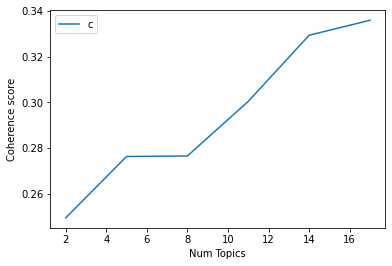

In [163]:
# Show graph
limit=20; start=2; step=3;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [166]:
optimodel = modellist[2]
coherence_values[2]

0.2765762183627411

In [168]:
optimodel.print_topics()

[(0,
  '0.074*"blow" + 0.060*"somewhere" + 0.037*"function" + 0.030*"building" + 0.024*"ozzy" + 0.023*"fun" + 0.020*"be" + 0.020*"strategy" + 0.017*"heave" + 0.015*"artist"'),
 (1,
  '0.068*"remain" + 0.048*"therefore" + 0.032*"political" + 0.026*"longer" + 0.024*"burden" + 0.020*"shell" + 0.017*"teacher" + 0.016*"week" + 0.015*"capable" + 0.014*"claim"'),
 (2,
  '0.057*"hit" + 0.052*"resilience" + 0.049*"structure" + 0.040*"infrastructure" + 0.029*"capable" + 0.020*"period" + 0.017*"excellent" + 0.017*"even" + 0.016*"minute" + 0.014*"life"'),
 (3,
  '0.106*"soccer" + 0.038*"twitter" + 0.038*"invest" + 0.024*"take" + 0.022*"heat" + 0.021*"pose" + 0.018*"cover" + 0.018*"loss" + 0.017*"intend" + 0.015*"remorse"'),
 (4,
  '0.049*"decision" + 0.040*"shell" + 0.031*"still" + 0.030*"send" + 0.025*"mean" + 0.024*"increase" + 0.024*"pass" + 0.020*"embrace" + 0.019*"structure" + 0.018*"play"'),
 (5,
  '0.118*"around" + 0.037*"run" + 0.037*"financially" + 0.026*"other" + 0.025*"regime" + 0.024*"